# Imports and definitions

In [1]:
import pandas as pd
import torch
import torchvision.transforms.functional as transform
import torchvision.transforms.functional as F
from EnsembleXAI import Ensemble, Metrics
from torchvision.transforms import Resize, CenterCrop
import os
from PIL import Image
from torchvision.models import resnet50, ResNet50_Weights
import urllib.request
import json
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from captum.attr import IntegratedGradients, Occlusion, NoiseTunnel
from captum.attr import visualization as viz
from torchvision import transforms
import matplotlib.pyplot as plt

In [2]:
with urllib.request.urlopen("https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json") as url:
    imagenet_classes_dict = json.load(url)

In [3]:
def download_class_images(class_id, masks_path):
    full_path = masks_path + class_id + "\\"
    kaggle_path = f"/ILSVRC/Data/CLS-LOC/train/{class_id}/"
    for file_name in os.listdir(full_path):
        file_name_jpeg = file_name[:-3] + 'JPEG'
        !kaggle competitions download -f {kaggle_path}{file_name_jpeg} -p ./images/{class_id}/ -c imagenet-object-localization-challenge


def download():
    skipped = []
    for class_id in os.listdir(masks_dir):
        image_class_path = os.path.join(images_dir, class_id)
        if os.path.exists(image_class_path) and len(os.listdir(image_class_path)) == 10:
            skipped.append(class_id)
            continue
        #download_class_images(class_id, masks_dir)
        print(f"Downloaded {class_id}")
    print("Full dirs: " + str(len(skipped)))


def images_list(image_path, resize=True):
    _crop = CenterCrop(224).forward
    _resize = Resize([232,232]).forward
    images = []
    for image_name in os.listdir(image_path):
        image = Image.open(image_path + image_name)
        if resize:
            image = _crop(_resize(image))
        images.append(image)
    return images

# Images load

In [4]:
input_dir = "\\".join(os.getcwd().split(sep="\\")[:-2] + ['input'])
masks_dir = input_dir + f'\\ImageNetS50\\train-semi-segmentation\\'
images_dir = os.getcwd() + "\\images\\"

In [5]:
print(os.listdir(images_dir))

['n01443537', 'n01491361', 'n01491361.png', 'n01531178', 'n01644373', 'n02104029', 'n02119022', 'n02123597', 'n02133161', 'n02165456', 'n02281406', 'n02325366', 'n02342885', 'n02396427', 'n02483362', 'n02504458', 'n02510455', 'n02690373', 'n02747177', 'n02783161', 'n02814533', 'n02859443', 'n02917067', 'n02992529', 'n03014705', 'n03047690', 'n03095699', 'n03197337', 'n03201208', 'n03445777', 'n03452741', 'n03584829', 'n03630383', 'n03775546', 'n03791053', 'n03874599', 'n03891251', 'n04026417', 'n04335435', 'n04380533', 'n04404412', 'n04447861', 'n04507155', 'n04522168', 'n04557648', 'n04562935', 'n04612504', 'n06794110', 'n07749582', 'n07831146', 'n12998815']


In [78]:
id = "n01491361"
def load_all(classid):
    all_img = images_list(images_dir + classid + "\\")
    all_img_org = images_list(images_dir + classid + "\\", resize=False)
    all_tens = [F.to_tensor(img) for img in all_img]
    all_msks = [(F.to_tensor(img)>0).float() for img in images_list(masks_dir + classid + "\\")]
    tens_img = torch.stack(all_tens)
    tens_msks = torch.stack(all_msks)[:,0].unsqueeze(dim=1).repeat(1, tens_img.shape[1], 1, 1)
    return all_img, all_img_org, all_tens, all_msks, tens_img, tens_msks
all_images, all_images_original, all_tensors, all_masks, tensor_images, tensor_masks = load_all("n01491361")

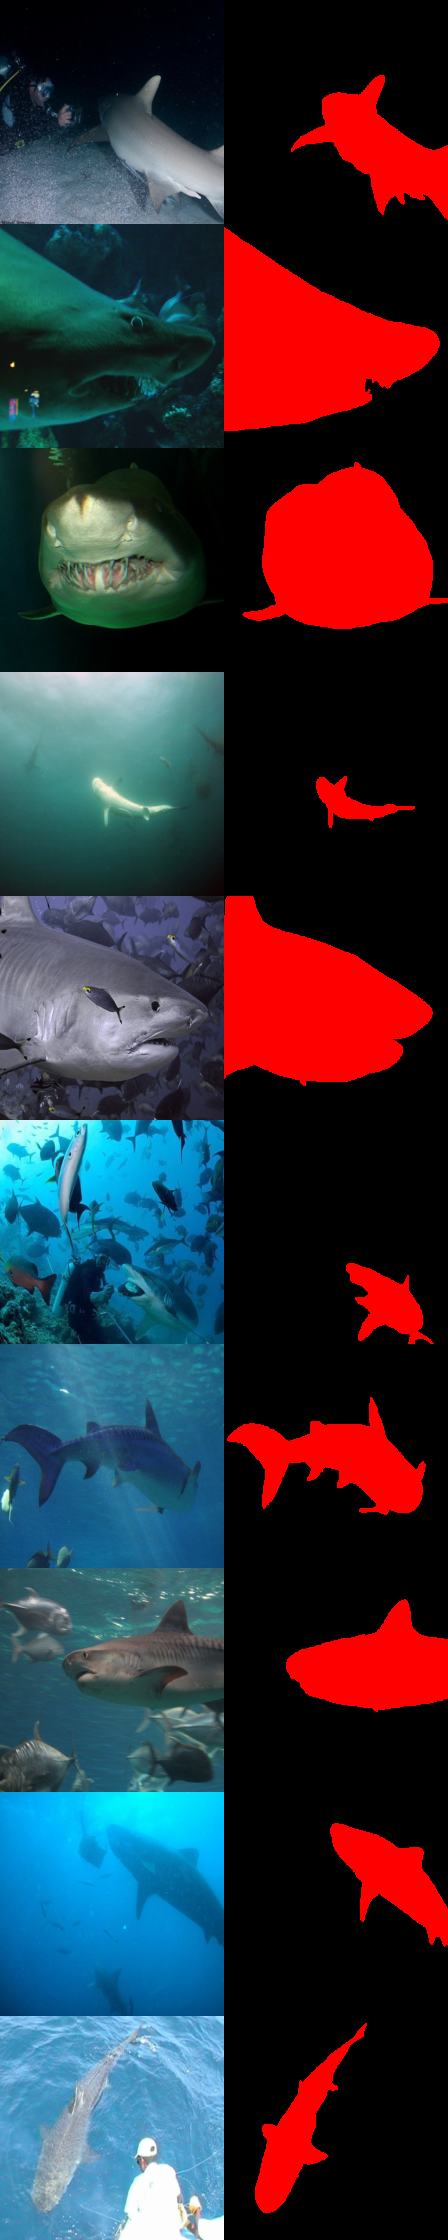

In [7]:
photos = []
for tensor, mask in zip(all_tensors, all_masks):
    photo = torch.cat([tensor, mask], dim=2)
    photos.append(photo)
display(transform.to_pil_image(torch.cat(photos, dim=1)))

# Model Loading

In [8]:
model = resnet50(weights=ResNet50_Weights.DEFAULT)
model.eval()
resnet_transform = ResNet50_Weights.DEFAULT.transforms()
pipeline = lambda images: torch.stack([resnet_transform(image) for image in images])
proper_data = pipeline(all_images_original)

In [9]:
outputs2 = model(proper_data)
_, preds2 = torch.max(outputs2, 1)
probs2 = torch.nn.functional.softmax(outputs2, dim=1)
[imagenet_classes_dict[str(i.item())][1] for i in preds2] # gar = Niszczukokształtne

['tiger_shark',
 'tiger_shark',
 'tiger_shark',
 'great_white_shark',
 'tiger_shark',
 'tiger_shark',
 'tiger_shark',
 'tiger_shark',
 'hammerhead',
 'gar']

# Single Explanations

In [10]:
single_pred = preds2[2].unsqueeze(dim=0)
single_data = proper_data[2].unsqueeze(dim=0)
integrated_gradients = IntegratedGradients(model)
attributions_ig = integrated_gradients.attribute(single_data, target=single_pred, n_steps=200)

Basing on: https://captum.ai/tutorials/Resnet_TorchVision_Interpret

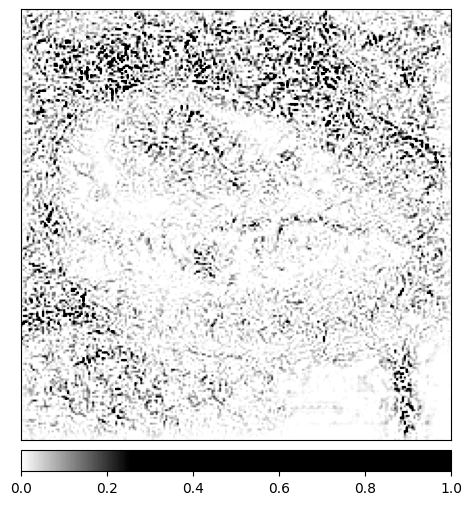

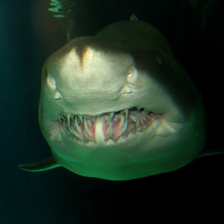

In [11]:
transformed_img = resnet_transform(all_images_original[2])
default_cmap = LinearSegmentedColormap.from_list('custom blue',
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

_ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             outlier_perc=1)
display(all_images[2])

In [12]:
import gc
gc.collect()

159

In [13]:
noise_tunnel = NoiseTunnel(integrated_gradients)

attributions_ig_nt = noise_tunnel.attribute(single_data, nt_samples=5, nt_type='smoothgrad_sq', target=single_pred)

In [14]:
attributions_ig_nt_all = torch.cat([noise_tunnel.attribute(tensor_images[i].unsqueeze(dim=0), nt_samples=5, nt_type='smoothgrad_sq', target=preds2[i].unsqueeze(dim=0)) for i in range(10)], dim=0)

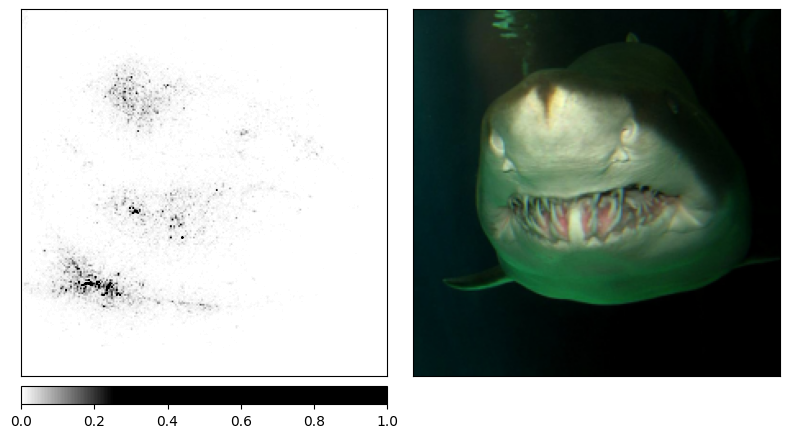

In [15]:
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig_nt.squeeze().numpy(), (1,2,0)),
                                      np.array(all_images[2]),
                                      ["heat_map", "original_image"],
                                      ["positive", "all"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

In [16]:
occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(single_data,
                                       strides = (3, 8, 8),
                                       target=single_pred,
                                       sliding_window_shapes=(3, 15, 15),
                                       baselines=0)

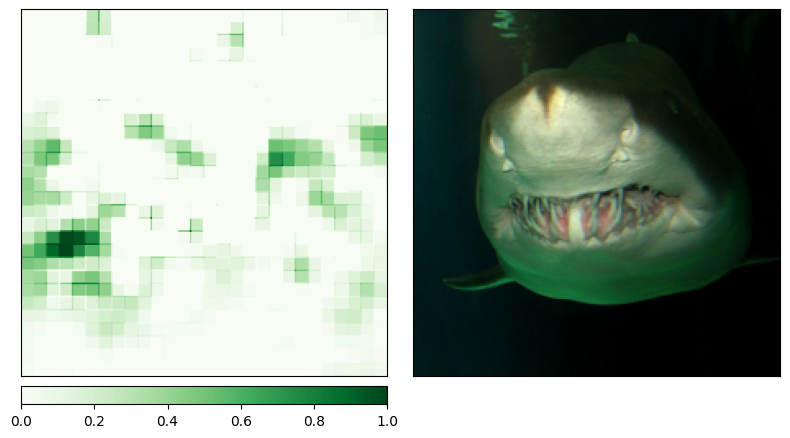

In [17]:
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.array(all_images[2]),
                                      ["heat_map", "original_image"],
                                      ["positive", "all"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                      )

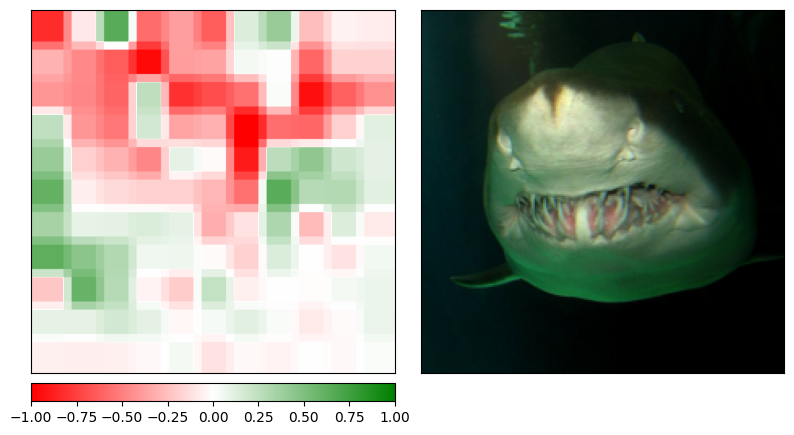

In [18]:
occlusion = Occlusion(model)

attributions_occ2 = occlusion.attribute(single_data,
                                       strides = (3, 20, 20),
                                       target=single_pred,
                                       sliding_window_shapes=(3, 25, 25),
                                       baselines=0)
_2 = viz.visualize_image_attr_multiple(np.transpose(attributions_occ2.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.array(all_images[2]),
                                      ["heat_map", "original_image"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                      )

In [19]:
occlusion = Occlusion(model)

attributions_occ_all_25 = occlusion.attribute(tensor_images,
                                        strides = (3, 20, 20),
                                        target = preds2,
                                        sliding_window_shapes = (3, 25, 25),
                                        baselines=0)

attributions_occ_all_15 = occlusion.attribute(tensor_images,
                                           strides = (3, 8, 8),
                                           target = preds2,
                                           sliding_window_shapes = (3, 15, 15),
                                           baselines=0)

In [28]:
def sample_xai(images):
    if images.shape[0] == 1:
        target = single_pred
    else:
        target = single_pred.repeat(images.shape[0])
    xai = occlusion.attribute(images,
                              strides = (3, 40, 40),
                              target=target,
                              sliding_window_shapes=(3,50, 50),
                              baselines=0)
    return xai
Metrics.stability(sample_xai, single_data.squeeze(dim=0), single_data.repeat(10,1,1,1))

0.0

# Ensembles

In [29]:
x = torch.cat([attributions_occ, attributions_ig_nt])
aggregated1 = Ensemble.aggregate(x, aggregating_func='avg')
aggregated2 = Ensemble.aggregate(x, aggregating_func='min')
aggregated3 = Ensemble.aggregate(x, aggregating_func='max')

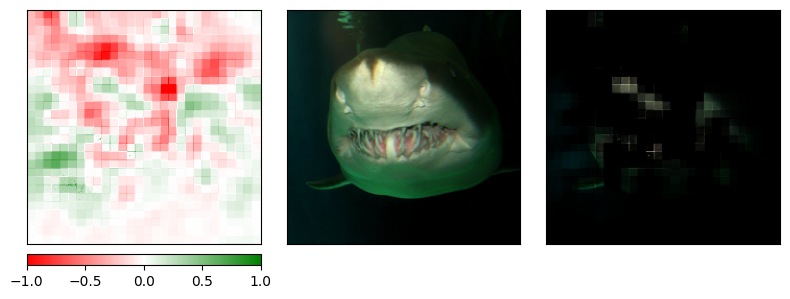

In [30]:
#display(transform.to_pil_image(aggregated1[0]))
_ = viz.visualize_image_attr_multiple(np.transpose(aggregated1.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.array(all_images[2]),
                                      ["heat_map", "original_image", "masked_image"],
                                      ["all", "positive", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                      )

In [32]:
all_stacked = torch.stack([attributions_occ_all_15, attributions_occ_all_25], dim=1)

In [33]:
aggreg_all1 = Ensemble.aggregate(all_stacked, aggregating_func='avg')
aggreg_all2 = Ensemble.aggregate(all_stacked, aggregating_func='min')
aggreg_all3 = Ensemble.aggregate(all_stacked, aggregating_func='max')

In [35]:
plt.style.use('fast')

In [36]:
def plot_explanations(images, explanations, columns_names, classes_predicted, cmaps=[default_cmap, None, None, None, None, None], method = "heat_map"):
    nrow, ncol = len(images), explanations.shape[1]+1
    fig, ax = plt.subplots(nrows = nrow, ncols = ncol, figsize=(14, 30))
    for col, col_name in zip(ax[0], columns_names):
        col.title.set_text(col_name)
    for i, img in enumerate(images):
        ax[i,0].xaxis.set_ticks_position("none")
        ax[i,0].yaxis.set_ticks_position("none")
        ax[i,0].set_yticklabels([])
        ax[i,0].set_xticklabels([])
        ax[i,0].imshow(np.array(img), vmin=0, vmax=255)
        ax[i,0].set_ylabel(classes_predicted[i], size='large')
        for j, col in enumerate(ax[i,1:]):
            expl = explanations[i,j]
            sign = "positive"
            if expl.amin() < 0:
                sign = "all"
            _ = viz.visualize_image_attr(np.transpose(expl.squeeze().numpy(), (1,2,0)),
                                         original_image=np.array(img),
                                         method=method,
                                         sign=sign,
                                         plt_fig_axis=(fig, col),
                                         show_colorbar=True,
                                         outlier_perc=2,
                                         cmap=cmaps[j],
                                         use_pyplot=False
                                         )
    plt.savefig(f"images/{id}.png")
    plt.show()

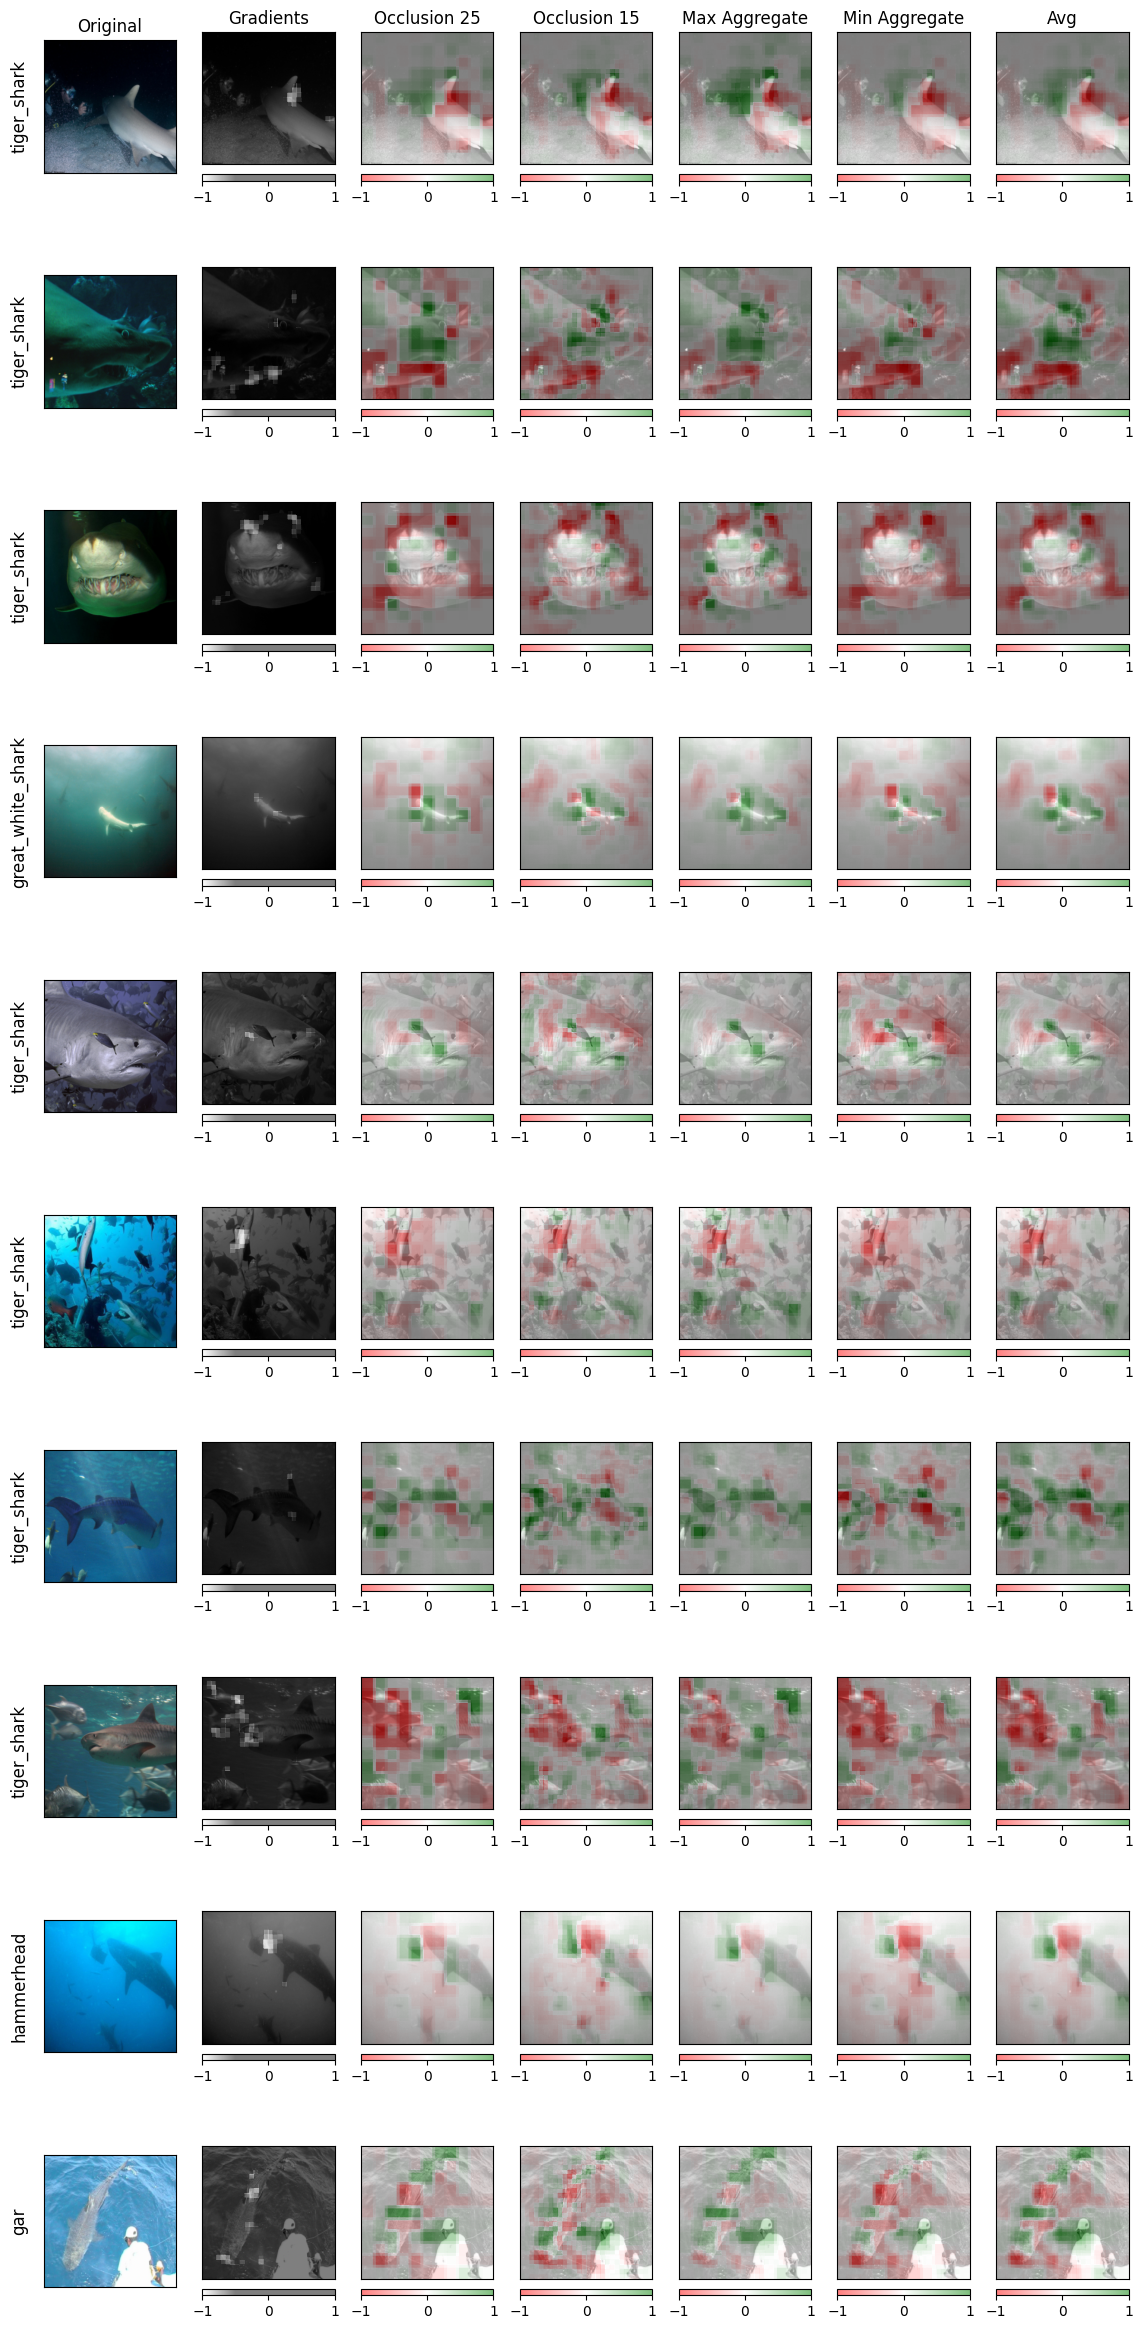

In [37]:
explanations_three = torch.cat([all_stacked, attributions_occ_all_15.unsqueeze(dim=1),aggreg_all3.unsqueeze(dim=1), aggreg_all2.unsqueeze(dim=1), aggreg_all1.unsqueeze(dim=1)], dim=1)
predicted_names = [imagenet_classes_dict[str(i.item())][1] for i in preds2]
col_names = ["Original", "Gradients", "Occlusion 25","Occlusion 15", "Max Aggregate", "Min Aggregate", "Avg"]
plot_explanations(all_images, explanations_three, col_names, predicted_names, method="blended_heat_map")

In [40]:
# per image
[Metrics.consistency(explanations_three[i]) for i in range(explanations_three.shape[0])]

[0.026851359754800797,
 0.035924434661865234,
 0.053964998573064804,
 0.028254946693778038,
 0.032272227108478546,
 0.037478700280189514,
 0.04926466941833496,
 0.05289948731660843,
 0.03560175374150276,
 0.022449374198913574]

In [112]:
# per explanation per image
[Metrics.accordance_recall(explanations_three[:, i], tensor_masks, 0.2) for i in range(explanations_three.shape[1])]

[tensor([0.2464, 0.0452, 0.0115, 0.3893, 0.0408, 0.0006, 0.0016, 0.0007, 0.1189,
         0.2853]),
 tensor([0.4922, 0.1172, 0.0250, 0.6898, 0.1879, 0.0093, 0.0320, 0.0000, 0.2546,
         0.6591]),
 tensor([0.2464, 0.0452, 0.0115, 0.3893, 0.0408, 0.0006, 0.0016, 0.0007, 0.1189,
         0.2853]),
 tensor([0.3271, 0.0717, 0.0162, 0.6818, 0.1249, 0.0099, 0.0336, 0.0000, 0.2064,
         0.4962]),
 tensor([0.4115, 0.0907, 0.0203, 0.3974, 0.1037, 0.0000, 0.0000, 0.0007, 0.1671,
         0.4482]),
 tensor([3.6730e-01, 4.7549e-02, 1.1511e-02, 4.2890e-01, 8.7768e-02, 7.3035e-03,
         1.6008e-03, 9.1424e-05, 1.6861e-01, 4.6998e-01])]

In [157]:
#per explanation per image
Metrics.accordance_precision(explanations_three[:, 3], tensor_masks, 0.2)

tensor([0.4434, 0.7592, 0.7299, 0.2598, 0.9959, 0.0235, 0.4058,    nan, 0.3836,
        0.3920])

In [155]:
expl_dict = {"Gradients":explanations_three[:, 0], "Occlusion 25":explanations_three[:, 1],
             "Occlusion 15":explanations_three[:, 2], "Max Aggregate":explanations_three[:, 3],
             "Min Aggregate":explanations_three[:, 4], "Avg Aggregate":explanations_three[:, 5]}
predict = lambda x: torch.nn.Softmax(dim=0)(model(x))
def dict_to_matrix(original_data, explanations_dict, predictor, masks_tensor):
    df = pd.DataFrame(columns=["Decision Impact Ratio", "Confidence Impact Ratio", "Average Recall", "Average Precision", "F1_score", "IOU"])
    for key, value in explanations_dict.items():
        df.loc[key, "Decision Impact Ratio"] = Metrics.decision_impact_ratio(original_data, predictor, explanations_dict[key], 0.1, 0)
        df.loc[key, "Confidence Impact Ratio"] = Metrics.confidence_impact_ratio(original_data, predictor, explanations_dict[key], 0.1, 0)
        df.loc[key, "Average Recall"] = torch.mean(Metrics.accordance_recall(explanations_dict[key], masks_tensor, 0.1)).item()
        df.loc[key, "Average Precision"] = torch.mean(Metrics.accordance_precision(explanations_dict[key], masks_tensor, 0.1)).item()
        df.loc[key, "F1_score"] = Metrics.F1_score(explanations_dict[key], masks_tensor)
        df.loc[key, "IOU"] = Metrics.intersection_over_union(explanations_dict[key], masks_tensor)
    return df

In [156]:
dict_to_matrix(proper_data, expl_dict, predict, tensor_masks)

,Decision Impact Ratio,Confidence Impact Ratio,Average Recall,Average Precision,F1_score,IOU
Gradients,0.9,-0.027287,0.306483,0.450906,0.360148,0.00631
Occlusion 25,0.8,-0.002501,0.459913,0.375963,0.359526,0.025647
Occlusion 15,0.9,-0.027287,0.306483,0.450906,0.360148,0.00631
Max Aggregate,0.8,-0.039502,0.415655,0.426757,0.360262,0.025915
Min Aggregate,0.5,0.02304,0.350741,0.385015,0.359415,0.006926
Avg Aggregate,0.7,-0.034366,0.362283,0.41162,0.359399,0.008472


In [160]:
torch.maximum(torch.Tensor([1,-1,3,4,-2]), torch.Tensor([0,0,0,0,0]))

tensor([1., 0., 3., 4., 0.])